In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# ImageNet normalization constants
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD = [0.229, 0.224, 0.225]

# Training transformations with data augmentation - Inception models use 299x299 input size
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(size=299, scale=(0.9, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=10),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.05, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Validation and test transformations without augmentation
val_test_transform = transforms.Compose([
    transforms.Resize((299, 299)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths) and tissue type (labels) columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type label encoding
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding
    """
    # Create training dataset and fit label encoder
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True
    )
    
    # Get the fitted encoder
    le = train_dataset.get_label_encoder()
    
    # Create validation dataset using the same encoder
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    # Create test dataset using the same encoder
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le
    )
    
    return train_dataset, val_dataset, test_dataset, le

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/data/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/data/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/data/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

print(f"Tissue Types: {label_encoder.classes_}")
# Print encoding information

Tissue Types: ['HGC' 'LGC' 'NST' 'NTL']


# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels in train_loader:
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        plt.show()

# Model Definitions

In [12]:
def create_inception_v4_model(num_classes=4, pretrained=True):
    """Create Inception V4 model for bladder tissue classification"""
    model = timm.create_model('inception_v4', pretrained=pretrained, num_classes=num_classes)
    return model

def create_inception_resnet_v2_model(num_classes=4, pretrained=True):
    """Create Inception ResNet V2 model for bladder tissue classification"""
    model = timm.create_model('inception_resnet_v2', pretrained=pretrained, num_classes=num_classes)
    return model

# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train Inception V4

Training Inception V4


model.safetensors:   0%|          | 0.00/171M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:23<00:00,  1.59it/s, Loss=0.8040, Acc=0.6974]


Train Loss: 0.8040 Acc: 0.6974 Macro-F1: 0.6507


Val : 100%|██████████| 10/10 [00:02<00:00,  4.55it/s, Loss=1.9792, Acc=0.4836]


Val Loss: 1.9792 Acc: 0.4836 Macro-F1: 0.4010
✓ New best model saved with validation macro-F1: 0.4010

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.4532, Acc=0.8462]


Train Loss: 0.4532 Acc: 0.8462 Macro-F1: 0.8030


Val : 100%|██████████| 10/10 [00:01<00:00,  5.26it/s, Loss=0.4839, Acc=0.8125]


Val Loss: 0.4839 Acc: 0.8125 Macro-F1: 0.7602
✓ New best model saved with validation macro-F1: 0.7602

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.2827, Acc=0.9079]


Train Loss: 0.2827 Acc: 0.9079 Macro-F1: 0.8809


Val : 100%|██████████| 10/10 [00:01<00:00,  5.17it/s, Loss=0.2290, Acc=0.9112]


Val Loss: 0.2290 Acc: 0.9112 Macro-F1: 0.9069
✓ New best model saved with validation macro-F1: 0.9069

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.2564, Acc=0.9194]


Train Loss: 0.2564 Acc: 0.9194 Macro-F1: 0.9031


Val : 100%|██████████| 10/10 [00:02<00:00,  4.90it/s, Loss=0.9117, Acc=0.8388]


Val Loss: 0.9117 Acc: 0.8388 Macro-F1: 0.7598

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.3454, Acc=0.8923]


Train Loss: 0.3454 Acc: 0.8923 Macro-F1: 0.8588


Val : 100%|██████████| 10/10 [00:01<00:00,  5.08it/s, Loss=0.3460, Acc=0.8849]


Val Loss: 0.3460 Acc: 0.8849 Macro-F1: 0.8484

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.2151, Acc=0.9211]


Train Loss: 0.2151 Acc: 0.9211 Macro-F1: 0.9049


Val : 100%|██████████| 10/10 [00:01<00:00,  5.11it/s, Loss=0.1130, Acc=0.9539]


Val Loss: 0.1130 Acc: 0.9539 Macro-F1: 0.9462
✓ New best model saved with validation macro-F1: 0.9462

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.1649, Acc=0.9465]


Train Loss: 0.1649 Acc: 0.9465 Macro-F1: 0.9320


Val : 100%|██████████| 10/10 [00:01<00:00,  5.12it/s, Loss=0.2637, Acc=0.9145]


Val Loss: 0.2637 Acc: 0.9145 Macro-F1: 0.9006

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.1319, Acc=0.9449]


Train Loss: 0.1319 Acc: 0.9449 Macro-F1: 0.9345


Val : 100%|██████████| 10/10 [00:01<00:00,  5.15it/s, Loss=0.0574, Acc=0.9868]


Val Loss: 0.0574 Acc: 0.9868 Macro-F1: 0.9810
✓ New best model saved with validation macro-F1: 0.9810

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0822, Acc=0.9737]


Train Loss: 0.0822 Acc: 0.9737 Macro-F1: 0.9633


Val : 100%|██████████| 10/10 [00:01<00:00,  5.16it/s, Loss=0.0398, Acc=0.9934]


Val Loss: 0.0398 Acc: 0.9934 Macro-F1: 0.9904
✓ New best model saved with validation macro-F1: 0.9904

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0698, Acc=0.9794]


Train Loss: 0.0698 Acc: 0.9794 Macro-F1: 0.9747


Val : 100%|██████████| 10/10 [00:01<00:00,  5.08it/s, Loss=0.0411, Acc=0.9836]


Val Loss: 0.0411 Acc: 0.9836 Macro-F1: 0.9748

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0414, Acc=0.9885]


Train Loss: 0.0414 Acc: 0.9885 Macro-F1: 0.9854


Val : 100%|██████████| 10/10 [00:01<00:00,  5.09it/s, Loss=0.0300, Acc=0.9901]


Val Loss: 0.0300 Acc: 0.9901 Macro-F1: 0.9878

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.71it/s, Loss=0.0408, Acc=0.9893]


Train Loss: 0.0408 Acc: 0.9893 Macro-F1: 0.9849


Val : 100%|██████████| 10/10 [00:01<00:00,  5.13it/s, Loss=0.0283, Acc=0.9934]


Val Loss: 0.0283 Acc: 0.9934 Macro-F1: 0.9907
✓ New best model saved with validation macro-F1: 0.9907

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0293, Acc=0.9926]


Train Loss: 0.0293 Acc: 0.9926 Macro-F1: 0.9908


Val : 100%|██████████| 10/10 [00:01<00:00,  5.17it/s, Loss=0.0183, Acc=0.9967]


Val Loss: 0.0183 Acc: 0.9967 Macro-F1: 0.9933
✓ New best model saved with validation macro-F1: 0.9933

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0339, Acc=0.9926]


Train Loss: 0.0339 Acc: 0.9926 Macro-F1: 0.9897


Val : 100%|██████████| 10/10 [00:01<00:00,  5.21it/s, Loss=0.0117, Acc=1.0000]


Val Loss: 0.0117 Acc: 1.0000 Macro-F1: 1.0000
✓ New best model saved with validation macro-F1: 1.0000

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0230, Acc=0.9942]


Train Loss: 0.0230 Acc: 0.9942 Macro-F1: 0.9941


Val : 100%|██████████| 10/10 [00:01<00:00,  5.01it/s, Loss=0.0111, Acc=1.0000]


Val Loss: 0.0111 Acc: 1.0000 Macro-F1: 1.0000

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0197, Acc=0.9959]


Train Loss: 0.0197 Acc: 0.9959 Macro-F1: 0.9944


Val : 100%|██████████| 10/10 [00:01<00:00,  5.18it/s, Loss=0.0095, Acc=0.9967]


Val Loss: 0.0095 Acc: 0.9967 Macro-F1: 0.9974

Epoch 17/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0207, Acc=0.9951]


Train Loss: 0.0207 Acc: 0.9951 Macro-F1: 0.9950


Val : 100%|██████████| 10/10 [00:01<00:00,  5.25it/s, Loss=0.0097, Acc=1.0000]


Val Loss: 0.0097 Acc: 1.0000 Macro-F1: 1.0000

Epoch 18/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0290, Acc=0.9918]


Train Loss: 0.0290 Acc: 0.9918 Macro-F1: 0.9879


Val : 100%|██████████| 10/10 [00:01<00:00,  5.15it/s, Loss=0.0104, Acc=1.0000]


Val Loss: 0.0104 Acc: 1.0000 Macro-F1: 1.0000

Epoch 19/25
----------


Train : 100%|██████████| 38/38 [00:22<00:00,  1.70it/s, Loss=0.0232, Acc=0.9934]


Train Loss: 0.0232 Acc: 0.9934 Macro-F1: 0.9913


Val : 100%|██████████| 10/10 [00:01<00:00,  5.26it/s, Loss=0.0109, Acc=1.0000]


Val Loss: 0.0109 Acc: 1.0000 Macro-F1: 1.0000
Early stopping triggered after 19 epochs
Training complete in 7m 48s
Best validation macro-F1: 1.0000


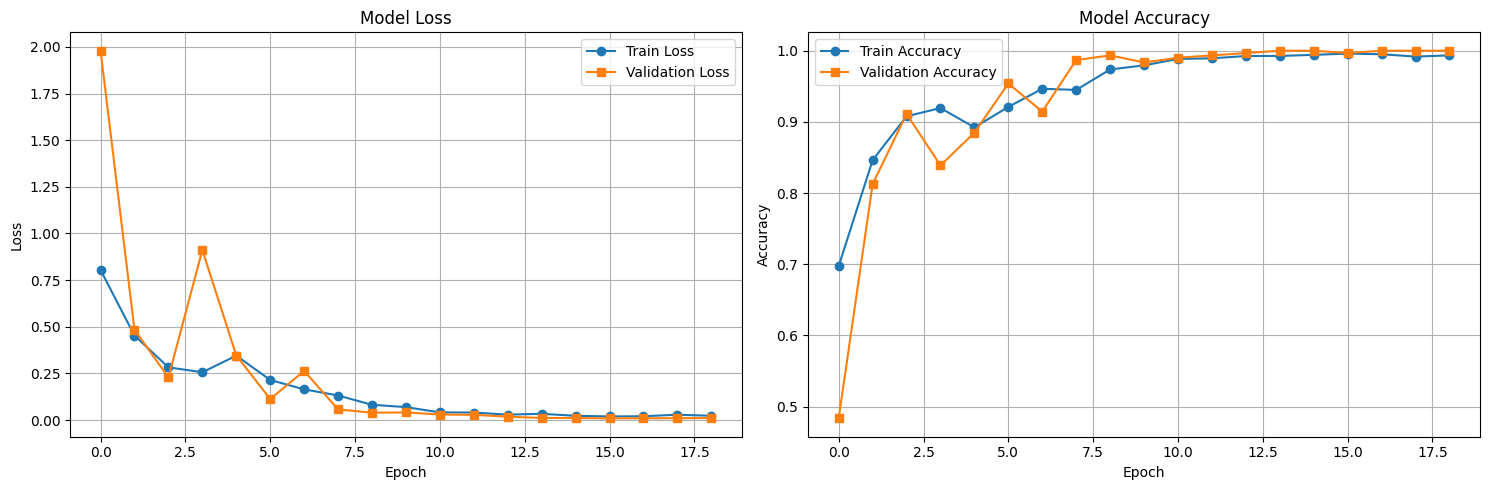

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.59it/s]


Test Accuracy: 52.38%
Test Loss: 1.8514

Classification Report:
              precision    recall  f1-score   support

         HGC       0.81      0.47      0.60        74
         LGC       0.31      0.25      0.27        53
         NST       0.81      0.81      0.81        37
         NTL       0.31      0.84      0.46        25

    accuracy                           0.52       189
   macro avg       0.56      0.59      0.53       189
weighted avg       0.61      0.52      0.53       189


Confusion Matrix:
[[35 29  1  9]
 [ 8 13  2 30]
 [ 0  0 30  7]
 [ 0  0  4 21]]

ROC-AUC Scores:
Macro-average AUC: 0.8183
Micro-average AUC: 0.7928
HGC AUC: 0.8915
LGC AUC: 0.6070
NST AUC: 0.9091
NTL AUC: 0.8654


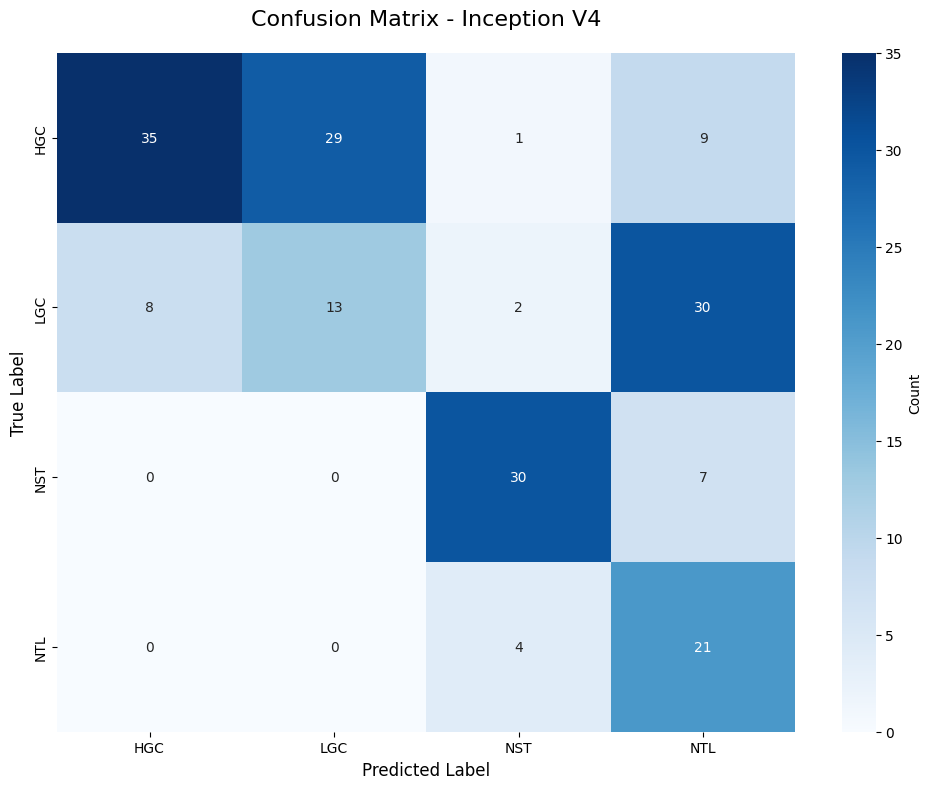

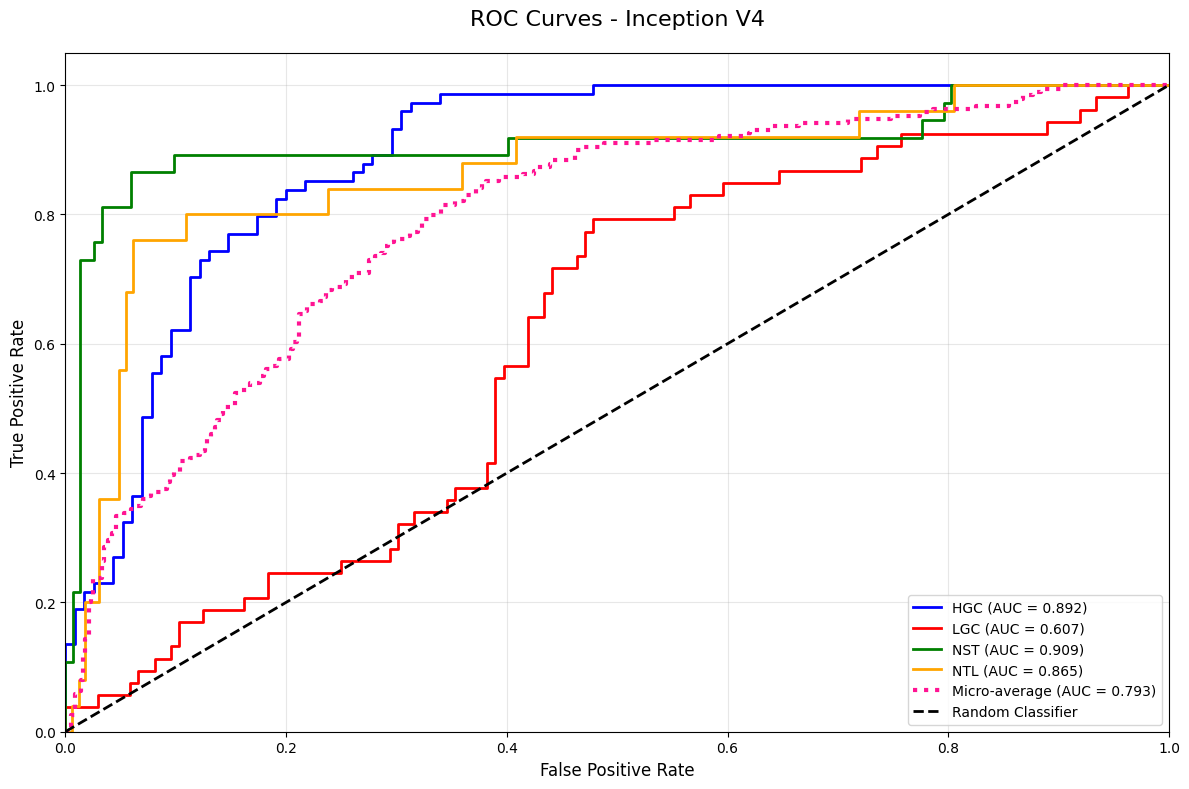


Inception V4 training and evaluation complete!


In [16]:
print("=" * 80)
print("Training Inception V4")
print("=" * 80)

# Create model
inception_v4 = create_inception_v4_model(num_classes=4, pretrained=True)

# Create trainer
trainer_v4 = ModelTrainer(inception_v4, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_v4 = trainer_v4.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="inception_v4")

# Plot training history
trainer_v4.plot_training_history(save_path='inception_v4_training_history.png')

# Evaluate model
results_v4 = trainer_v4.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_v4['confusion_matrix'], class_names, 'Inception V4',
                      save_path='inception_v4_confusion_matrix.png')

# Plot ROC curves
roc_auc_v4 = plot_roc_curves(results_v4['labels'], results_v4['probabilities'], class_names, 'Inception V4',
                              save_path='inception_v4_roc_curves.png')
# Store results
results_v4['model_name'] = 'Inception V4'
results_v4['roc_auc'] = roc_auc_v4
all_results.append(results_v4)

print("\nInception V4 training and evaluation complete!")

## Train Inception ResNet V2

Training Inception ResNet V2


model.safetensors:   0%|          | 0.00/224M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.8541, Acc=0.6571]


Train Loss: 0.8541 Acc: 0.6571 Macro-F1: 0.6102


Val : 100%|██████████| 10/10 [00:02<00:00,  4.48it/s, Loss=0.9213, Acc=0.7171]


Val Loss: 0.9213 Acc: 0.7171 Macro-F1: 0.6687
✓ New best model saved with validation macro-F1: 0.6687

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.3248, Acc=0.8832]


Train Loss: 0.3248 Acc: 0.8832 Macro-F1: 0.8496


Val : 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Loss=0.2537, Acc=0.9178]


Val Loss: 0.2537 Acc: 0.9178 Macro-F1: 0.9214
✓ New best model saved with validation macro-F1: 0.9214

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.55it/s, Loss=0.2225, Acc=0.9342]


Train Loss: 0.2225 Acc: 0.9342 Macro-F1: 0.9117


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=0.1505, Acc=0.9441]


Val Loss: 0.1505 Acc: 0.9441 Macro-F1: 0.9246
✓ New best model saved with validation macro-F1: 0.9246

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.1644, Acc=0.9400]


Train Loss: 0.1644 Acc: 0.9400 Macro-F1: 0.9262


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=0.1653, Acc=0.9276]


Val Loss: 0.1653 Acc: 0.9276 Macro-F1: 0.8927

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.1298, Acc=0.9498]


Train Loss: 0.1298 Acc: 0.9498 Macro-F1: 0.9368


Val : 100%|██████████| 10/10 [00:02<00:00,  4.46it/s, Loss=0.2702, Acc=0.8816]


Val Loss: 0.2702 Acc: 0.8816 Macro-F1: 0.8921

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.0772, Acc=0.9737]


Train Loss: 0.0772 Acc: 0.9737 Macro-F1: 0.9721


Val : 100%|██████████| 10/10 [00:02<00:00,  4.40it/s, Loss=0.1682, Acc=0.9276]


Val Loss: 0.1682 Acc: 0.9276 Macro-F1: 0.8894

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.0789, Acc=0.9720]


Train Loss: 0.0789 Acc: 0.9720 Macro-F1: 0.9628


Val : 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, Loss=0.0485, Acc=0.9868]


Val Loss: 0.0485 Acc: 0.9868 Macro-F1: 0.9893
✓ New best model saved with validation macro-F1: 0.9893

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.0521, Acc=0.9844]


Train Loss: 0.0521 Acc: 0.9844 Macro-F1: 0.9792


Val : 100%|██████████| 10/10 [00:02<00:00,  4.39it/s, Loss=0.0263, Acc=0.9934]


Val Loss: 0.0263 Acc: 0.9934 Macro-F1: 0.9904
✓ New best model saved with validation macro-F1: 0.9904

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.0309, Acc=0.9877]


Train Loss: 0.0309 Acc: 0.9877 Macro-F1: 0.9852


Val : 100%|██████████| 10/10 [00:02<00:00,  4.41it/s, Loss=0.0234, Acc=0.9934]


Val Loss: 0.0234 Acc: 0.9934 Macro-F1: 0.9904

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.0152, Acc=0.9975]


Train Loss: 0.0152 Acc: 0.9975 Macro-F1: 0.9981


Val : 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Loss=0.0229, Acc=0.9934]


Val Loss: 0.0229 Acc: 0.9934 Macro-F1: 0.9904

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.0221, Acc=0.9951]


Train Loss: 0.0221 Acc: 0.9951 Macro-F1: 0.9959


Val : 100%|██████████| 10/10 [00:02<00:00,  4.44it/s, Loss=0.0221, Acc=0.9934]


Val Loss: 0.0221 Acc: 0.9934 Macro-F1: 0.9904

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.0173, Acc=0.9951]


Train Loss: 0.0173 Acc: 0.9951 Macro-F1: 0.9961


Val : 100%|██████████| 10/10 [00:02<00:00,  4.30it/s, Loss=0.0165, Acc=0.9934]


Val Loss: 0.0165 Acc: 0.9934 Macro-F1: 0.9904

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:24<00:00,  1.56it/s, Loss=0.0151, Acc=0.9975]


Train Loss: 0.0151 Acc: 0.9975 Macro-F1: 0.9969


Val : 100%|██████████| 10/10 [00:02<00:00,  4.42it/s, Loss=0.0165, Acc=0.9934]


Val Loss: 0.0165 Acc: 0.9934 Macro-F1: 0.9904
Early stopping triggered after 13 epochs
Training complete in 5m 49s
Best validation macro-F1: 0.9904


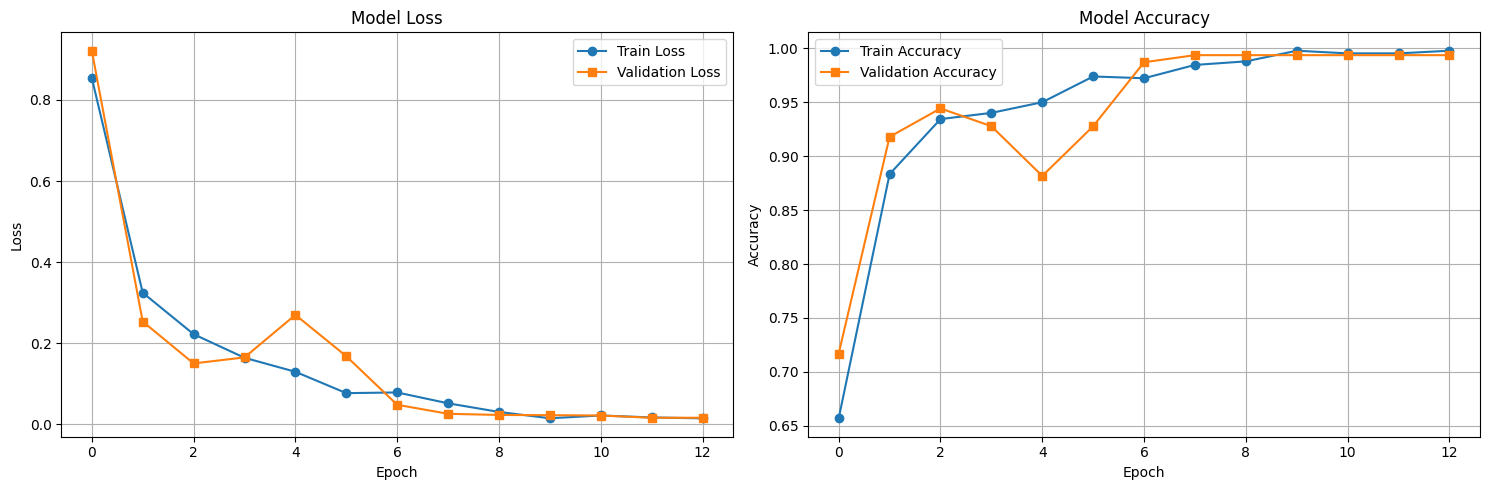

Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.64it/s]


Test Accuracy: 38.10%
Test Loss: 2.6345

Classification Report:
              precision    recall  f1-score   support

         HGC       0.41      0.23      0.30        74
         LGC       0.32      0.13      0.19        53
         NST       0.60      0.78      0.68        37
         NTL       0.24      0.76      0.37        25

    accuracy                           0.38       189
   macro avg       0.40      0.48      0.38       189
weighted avg       0.40      0.38      0.35       189


Confusion Matrix:
[[17 15 11 31]
 [24  7  2 20]
 [ 0  0 29  8]
 [ 0  0  6 19]]

ROC-AUC Scores:
Macro-average AUC: 0.7499
Micro-average AUC: 0.7048
HGC AUC: 0.6469
LGC AUC: 0.6842
NST AUC: 0.8903
NTL AUC: 0.7783


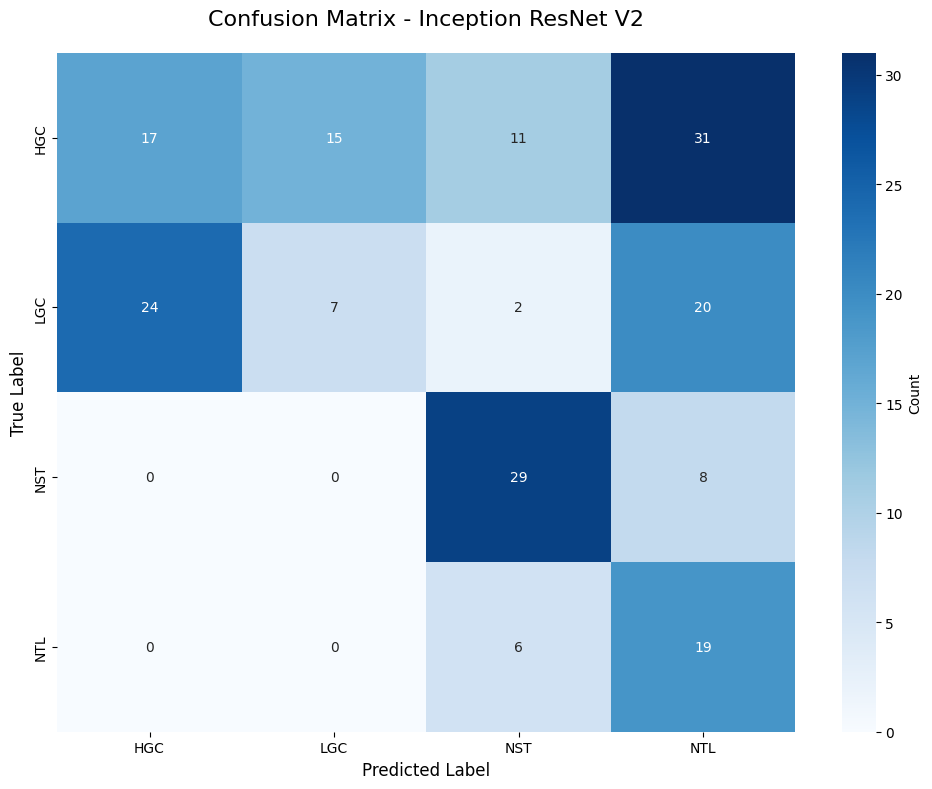

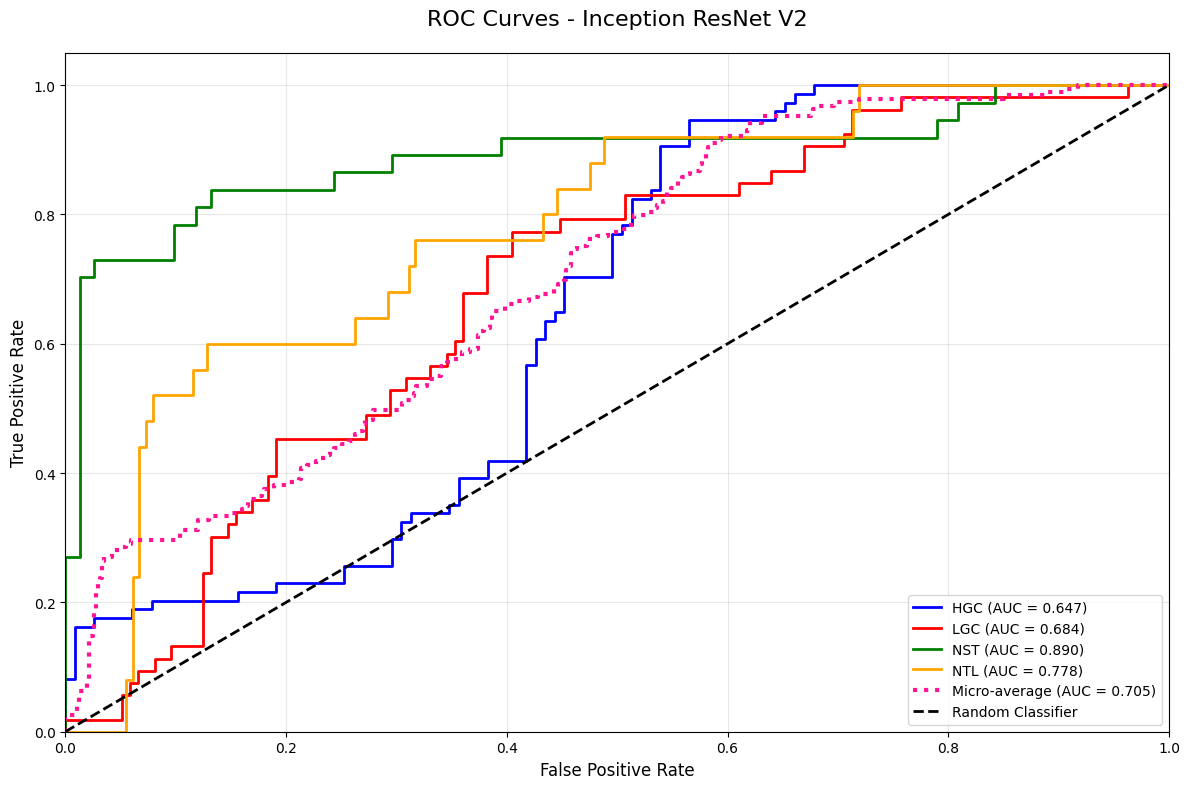


Inception ResNet V2 training and evaluation complete!


In [17]:
print("=" * 80)
print("Training Inception ResNet V2")
print("=" * 80)

# Create model
inception_resnet_v2 = create_inception_resnet_v2_model(num_classes=4, pretrained=True)

# Create trainer
trainer_resnet_v2 = ModelTrainer(inception_resnet_v2, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_resnet_v2 = trainer_resnet_v2.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="inception_resnet_v2")

# Plot training history
trainer_resnet_v2.plot_training_history(save_path='inception_resnet_v2_training_history.png')

# Evaluate model
results_resnet_v2 = trainer_resnet_v2.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_resnet_v2['confusion_matrix'], class_names, 'Inception ResNet V2',
                      save_path='inception_resnet_v2_confusion_matrix.png')

# Plot ROC curves
roc_auc_resnet_v2 = plot_roc_curves(results_resnet_v2['labels'], results_resnet_v2['probabilities'], class_names, 'Inception ResNet V2',
                                     save_path='inception_resnet_v2_roc_curves.png')
# Store results
results_resnet_v2['model_name'] = 'Inception ResNet V2'
results_resnet_v2['roc_auc'] = roc_auc_resnet_v2
all_results.append(results_resnet_v2)

print("\nInception ResNet V2 training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'Inception_V4_ResNetV2_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())



Metrics saved to: Inception_V4_ResNetV2_metrics.csv

Metrics Summary:
                 Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0         Inception V4         52.380952      1.851401             0.561930          0.592267      0.534827                0.605678             0.523810         0.530115       0.813953    0.472973  0.598291         74.0       0.309524    0.245283  0.273684         53.0       0.810811    0.810811  0.810811         37.0       0.313433        0.84  0.456522         25.0   0.818252   0.792792  0.891539  0.606964  0.909139